<img src="https://github.com/PKhosravi-CityTech/LightCnnRad/raw/main/Images/BioMindLogo.png" alt="BioMind AI Lab Logo" width="150" height="150" align="left" style="margin-bottom: 40px;"> **Repository Developed by Pegah Khosravi, Principal Investigator of the BioMind AI Lab**

Welcome to this repository! This repository is a result of collaborative efforts from our dedicated team at the lab. We are committed to advancing the field of biomedical AI and pushing the boundaries of medical data analysis. Your interest and contributions to our work are greatly appreciated. For more information about our lab and ongoing projects, please visit the [BioMind AI Lab website](https://sites.google.com/view/biomind-ai-lab). Thank you for your interest and support!


#LightCnnRad

💠 A lightweight CNN developed specifically for radiology image analysis.


Introducing "LightCnnRad," an innovative CNN algorithm meticulously crafted for the precise analysis of radiology images, including MRI and CT scans. The uniqueness of LightCnnRad lies in its minimal number of hidden layers, strategically designed to strike a harmonious balance between complexity and efficiency. This lightweight architecture not only ensures that the model can be trained from scratch but also guards against the perils of overfitting, a common challenge in deep learning. LightCnnRad's foundation is rooted in its adaptability to radiology image datasets, enabling it to capture intricate nuances while maintaining generalization prowess. The algorithm's streamlined structure allows it to swiftly process these images, making it an ideal choice for medical professionals seeking rapid and accurate insights. With LightCnnRad, the realm of radiology image analysis is poised to witness a significant leap forward in both accuracy and efficiency.





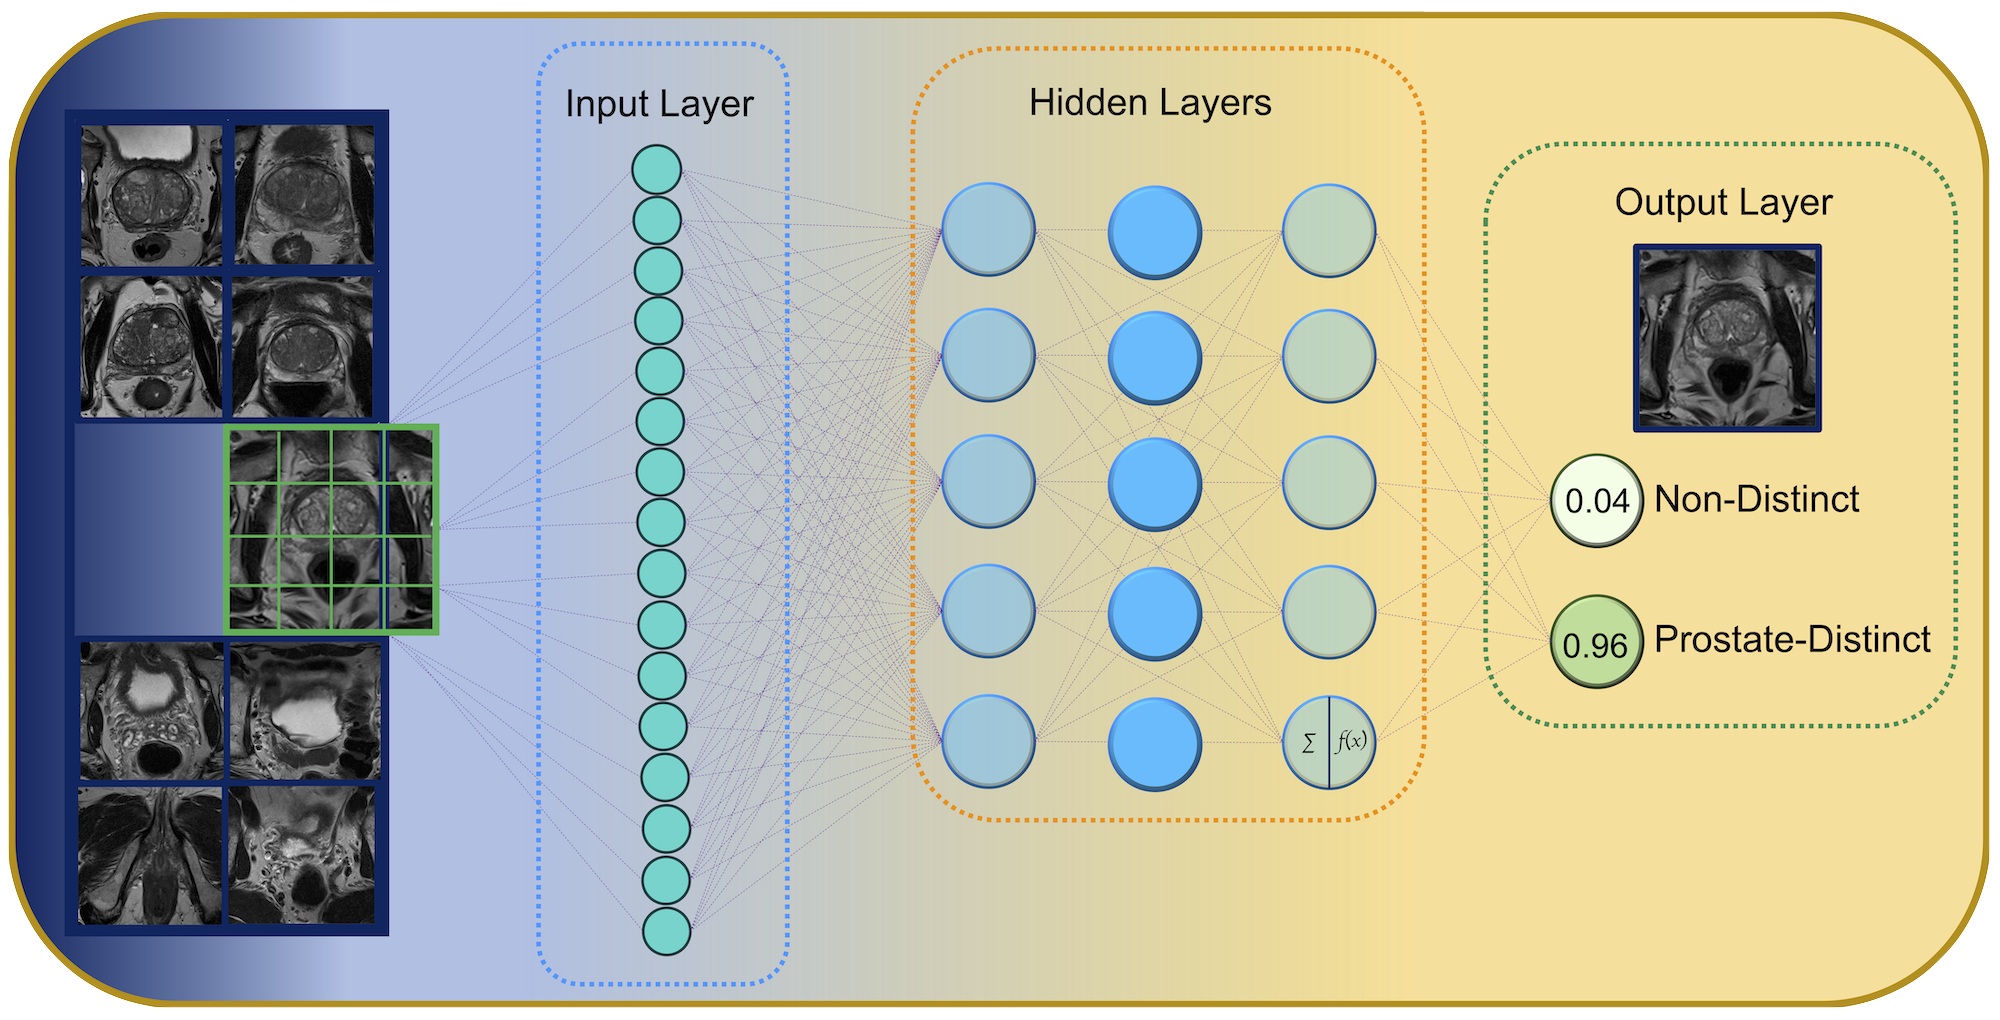

The provided GitHub repository for LightCnnRad offers a comprehensive resource to both experts and beginners in the field of deep learning and radiology image analysis. Notably, the repository includes a meticulously crafted Colab file, complete with step-by-step instructions. This feature empowers even those new to deep learning to confidently navigate through the process of training the model. With a user-friendly approach, the Colab file serves as a valuable guide, enabling beginners to embark on a successful journey of model training without unnecessary complexities. Whether you're an experienced practitioner or a novice eager to explore the world of deep learning, the LightCnnRad GitHub repository equips you with the tools and guidance needed to harness the power of this innovative algorithm effectively.

💠 Please access the "LightCnnRad.ipynb" file on Google Colab and follow the provided instructions. Additionally, you can find sample images labeled as "Data.zip" in the "Images" folder. Here, I will be training a model capable of distinguishing between distinct prostate images or scans containing the prostate gland (Distinct) and other Non-Distinct scans. Please be aware that these images are provided as examples to demonstrate the required format, and you will need to gather a larger set of images for training the model.

✅ The development of LightCnnRad is a collaborative effort, with credit attributed to the contributions of Eshaan Haque, Aashi Hirani, Howe Chen, WintPyae LynnHtaik, Tassadit Lounes, Raecine Greaves, Mehnaz Hoque, Maxwell Boger, Charlene Chung, and Ebtisam Mohamed.

#GPU
While it's possible to execute this script on a CPU, I'm currently utilizing a GPU for this purpose. Consequently, please make sure that your GPU is enabled before you proceed with uploading the image and executing the code. You can adjust the GPU settings under the "Runtime" section.

Import all the necessary libraries.

In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import random
from torchsummary import summary
from torch.optim.adamw import AdamW
from torch.optim.adamax import Adamax
from torch.optim.sparse_adam import SparseAdam
from torch.optim.sgd import SGD
from torch.optim.adagrad import Adagrad
from torch.optim.rmsprop import RMSprop
import matplotlib.pyplot as plt
import time
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
from PIL import Image
import pathlib
import glob
import cv2
import csv
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

Checking the availiblity of GPU

In [2]:
torch.cuda.empty_cache()

#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [4]:
# Transformations to preprocess input images before feeding to the model
transformer = transforms.Compose([
    # Resize the image to (150, 150) pixels
    transforms.Resize((150, 150)),

    # Apply random horizontal flip for data augmentation
    transforms.RandomHorizontalFlip(),

    # Convert the image to a tensor (0-255 to 0-1), and reshape it to (C, H, W)
    # where C represents the number of channels (3 for RGB), and H, W are height and width
    transforms.ToTensor(),

    # Normalize the tensor values to a range of [-1, 1]
    # by applying (x - mean) / std where mean = 0.5 and std = 0.5
    transforms.Normalize(
        [0.5, 0.5, 0.5],   # Mean for each channel (RGB)
        [0.5, 0.5, 0.5]    # Standard deviation for each channel (RGB)
    )
])

This section sets up data loaders for training, validation, and testing. It loads images from specific directories, applies transformations, and creates batches for efficient processing during model training and evaluation.

In [5]:
# Path for training and validation directory
train_path = "Datasets/Alzheimer MRI/Train"
validation_path = "Datasets/Alzheimer MRI/Validation"
pred_path="Datasets/Alzheimer MRI/Test"

# Define data loaders for training and validation datasets
# DataLoader for training dataset
train_loader = DataLoader(
    torchvision.datasets.ImageFolder(train_path, transform=transformer),  # Use the previously defined transformer
    batch_size=32,         # Number of samples in each batch
    shuffle=True            # Shuffle the data for each epoch
)

# DataLoader for validation dataset
validation_loader = DataLoader(
    torchvision.datasets.ImageFolder(validation_path, transform=transformer),  # Use the same transformer
    batch_size=32,          # Number of samples in each batch
    shuffle=True            # Shuffle the data for each epoch
)

Here, we define the categories or classes within our dataset. It scans the training data directory, extracts the category names from the directory structure, and sorts them alphabetically for reference in our image classification task.

In [ ]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print('Categories: ', classes)

Let's define the Convolutional Neural Network (CNN) class

In [8]:
# Define a Convolutional Neural Network (CNN) class
class LightCnnRad(nn.Module):
    def __init__(self, num_classes=2):
        super(LightCnnRad, self).__init__()

        # Define the architecture of the CNN

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        # Batch normalization layer
        self.bn1 = nn.BatchNorm2d(num_features=12)
        # ReLU activation function
        self.relu1 = nn.ReLU()

        # Max pooling layer to reduce image size by factor 2
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=20, kernel_size=3, stride=1, padding=1)
        # ReLU activation function
        self.relu2 = nn.ReLU()

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Batch normalization layer
        self.bn3 = nn.BatchNorm2d(num_features=32)
        # ReLU activation function
        self.relu3 = nn.ReLU()

        # Fully connected layer to make predictions
        self.fc = nn.Linear(in_features=75 * 75 * 32, out_features=num_classes)

    # Forward propagation function
    def forward(self, input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)

        output = self.pool(output)

        output = self.conv2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)

        # Flatten the output from the convolutional layers
        output = output.view(-1, 32 * 75 * 75)

        # Fully connected layer to make predictions
        output = self.fc(output)

        return output


We define the class number as 2, indicating binary classification for our model.

In [ ]:
model=LightCnnRad(num_classes=2).to(device)

Now, let's define the optimizers and loss function.

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

Next, let's set the desired number of epochs for training the model.

In [15]:
num_epochs=100

Now, let's take a look at the number of images present in both the training and validation folders.

In [10]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
validation_count=len(glob.glob(validation_path+'/**/*.png'))
print(train_count,validation_count)

In [18]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Optional: Ensures that every run on the same machine yields the same result
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# Continue with the rest of your imports and code
import matplotlib.pyplot as plt
from torch.autograd import Variable



Now, we proceed with training the model for the specified number of epochs using the images from the training and validation folders. During each epoch, we assess the model's performance, ultimately saving the best-performing model. 

We implemented an early stopping mechanism in a CNN for image classification to enhance training efficiency and prevent overfitting. This mechanism halts training if the validation accuracy does not improve for five consecutive epochs. Throughout training, we monitor accuracies and losses, adjusting the model's parameters on a GPU or CPU as available. The training stops early when there is no improvement in validation accuracy beyond the set patience threshold, thus optimizing computational resources and ensuring the model generalizes well on new data.

Now, Let's train the model.

In [ ]:
# Lists to store accuracy and loss values for training and validation
train_acc_history = []
train_loss_history = []
validation_acc_history = []
validation_loss_history = []

best_accuracy = 0.0
total_start_time = time.time()

# Model training and saving best model
best_accuracy = 0.0
patience = 15 # Number of epochs to wait after last time validation accuracy improved.
patience_counter = 0  # Counter to track the number of epochs since the last improvement

for epoch in range(num_epochs):
    # Model training and evaluation on training dataset
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        optimizer.zero_grad()

        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        train_accuracy += int(torch.sum(prediction == labels.data))

    train_accuracy = train_accuracy / train_count
    train_loss = train_loss / train_count

    # Evaluation on validation dataset
    model.eval()

    validation_accuracy = 0.0
    validation_loss = 0.0

    for i, (images, labels) in enumerate(validation_loader):
        if torch.cuda.is_available():
            images = Variable(images.cuda())
            labels = Variable(labels.cuda())

        outputs = model(images)
        loss = loss_function(outputs, labels)

        validation_loss += loss.cpu().data * images.size(0)
        _, prediction = torch.max(outputs.data, 1)
        validation_accuracy += int(torch.sum(prediction == labels.data))

    validation_accuracy = validation_accuracy / validation_count
    validation_loss = validation_loss / validation_count

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy) +
          ' Validation Loss: ' + str(validation_loss) +
          ' Validation Accuracy: ' + str(validation_accuracy))

    # Append accuracy and loss values to the history lists
    train_acc_history.append(train_accuracy)
    train_loss_history.append(train_loss)
    validation_acc_history.append(validation_accuracy)
    validation_loss_history.append(validation_loss)
    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = validation_accuracy
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1

    if patience_counter > patience:
        print("Early stopping triggered.")
        break  # Exit from the training loop
    print('Patience couner:', patience_counter)
total_end_time = time.time()
total_duration = (total_end_time - total_start_time) / 60

print(f"Total Training Time: {total_duration:.2f} minutes")

Now, let's test the best model on a blind test set. You can proceed with the following code for prediction.

In [44]:
test_count=len(glob.glob(pred_path+'/**/*.png'))
print(test_count)

This illustrates the architecture of your model and the number of parameters that need to be calculated during the training process.

In [ ]:
checkpoint=torch.load("best_checkpoint.model")
model=LightCnnRad(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

In [ ]:
from torchsummary import summary

model=model.cuda()

summary(model, (3,150,150))

In [13]:
# Transformations to preprocess input images before feeding to the model
transformer = transforms.Compose([
    # Resize the image to (150, 150) pixels
    transforms.Resize((150, 150)),

    # Convert the image to a tensor (0-255 to 0-1), and reshape it to (C, H, W)
    # where C represents the number of channels (3 for RGB), and H, W are height and width
    transforms.ToTensor(),

    # Normalize the tensor values to a range of [-1, 1]
    # by applying (x - mean) / std where mean = 0.5 and std = 0.5
    transforms.Normalize(
        [0.5, 0.5, 0.5],   # Mean for each channel (RGB)
        [0.5, 0.5, 0.5]    # Standard deviation for each channel (RGB)
    )
])

This code defines a prediction function to assess new images using the trained LightCNNRad model. It processes each image, generates predictions, and stores them in a dictionary. Finally, the probabilities are printed in the desired format for further analysis.

In [ ]:
# Prediction function to predict class probabilities for an input image
def prediction(img_path, transformer, model):
    # Open and load the input image
    image = Image.open(img_path)

    # Apply transformations to the image
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    # Perform inference (no need to compute gradients)
    with torch.no_grad():
        input = Variable(image_tensor)
        output = model(input)

    # Calculate class probabilities using softmax
    prob = nn.functional.softmax(output, dim=1)

    # Convert the tensor to a numpy array and move it to CPU
    prob = prob.cpu().detach().numpy()

    return prob

# Load the trained model and move it to the appropriate device (CPU or GPU)
model = LightCnnRad(num_classes=2)  # Create an instance of the LightCnnRad
model.load_state_dict(checkpoint)  # Load the trained model's weights
if torch.cuda.is_available():
    model.cuda()  # Move the model to GPU if available

# Get a list of image paths to predict
images_path = glob.glob(pred_path + '/**/*.png')

# Dictionary to store predictions
pred_dict = {}

# Loop through each image and make predictions
for i in images_path:
    filename = i[i.rfind('/') + 1:]  # Extract the filename from the path
    prob_array = prediction(i, transformer, model)  # Get predicted probabilities
    pred_dict[filename] = prob_array  # Store the probabilities in the dictionary

# Print the probabilities in the desired format
for filename, prob_array in pred_dict.items():
    formatted_prob_array = np.array2string(
        prob_array, separator=', ', formatter={'float_kind': lambda x: f'{x:.8e}'}
    )
    print(f"'{filename}': np.array({formatted_prob_array}, dtype=np.float32),")

Now, let's save the results in a file named "predictions.csv".

This code segment performs predictions on images using the LightCNNRad model and saves the results to a CSV file. It iterates through the prediction dictionary and determines the predicted class and probability for each image, considering a threshold of 0.5. The results are then stored in 'predictions.csv' for further analysis.

In [ ]:
# Define the path for saving the CSV file
output_csv_path = 'Predictions.csv'

# Save prediction results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predicted Class', 'Probability'])

    for filename, prob_array in pred_dict.items():
        predicted_class = classes[1] if prob_array[0][1] > 0.5 else classes[0]  # Adjust the threshold as needed
        probability = prob_array[0][1]
        csvwriter.writerow([filename.split('\\')[1], predicted_class, probability])

print("Prediction results saved to", output_csv_path)

In addition to individual image predictions, this code segment extends the results to a patient-level analysis. It calculates a majority vote for each patient based on their individual image predictions, using a user-defined positive threshold (default: 0.5). The results are stored in 'predictions_vote.csv,' which contains true labels and the majority vote predictions. This approach enables a more comprehensive evaluation of patient-level outcomes, considering multiple scans per patient in the analysis.

In [ ]:
# Set the desired threshold for considering predictions as positive
positive_threshold = 0.5

# Define the path for saving the CSV file
output_csv_path = 'Predictions_vote.csv'

# Dictionary to store patient-wise predictions
patient_predictions = {}

# Populate the dictionary with individual image predictions
for filename, prob_array in pred_dict.items():
    patient_id = "_".join(filename.split('_')[:-1])
    prediction = prob_array[0][1]
    
    if patient_id not in patient_predictions:
        patient_predictions[patient_id] = []

    patient_predictions[patient_id].append(prediction)
# Calculate majority vote and save results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Prediction', 'Probability'])

    for patient_id, predictions in patient_predictions.items():
        majority_vote = sum(predictions) / len(predictions)
        predicted_class = classes[1] if majority_vote > positive_threshold else classes[0]
        if majority_vote >= positive_threshold or (1 - majority_vote) >= positive_threshold:
            csvwriter.writerow([patient_id.split('\\')[-2], predicted_class, majority_vote])

print("Prediction results saved to", output_csv_path)


Finally, let's draw the ROC curve and Confusion Matrix, along with other measurements.

In [ ]:
# Load data from predictions.csv
df = pd.read_csv('Predictions_vote.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']
predicted_probs = df['Probability']

# Convert labels to binary format (0 for 'N_' and 1 for 'Y_')
true_labels = true_labels.apply(lambda x: 0 if x.startswith(classes[0]) else 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
'ROC Curve of VGG16 Model'
plt.title("ROC Curve of DepthNet for Treatment Response Classification \n Using Breast Cancer MRI Images", pad=10)
plt.legend(loc="lower right")

# Save the figure to a PDF file
plt.savefig('roc.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Read the CSV file containing predictions
df = pd.read_csv('Predictions_vote.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']

# Preprocess true labels to extract class labels (e.g., 'Dis' or 'Non')

true_labels_processed = [label for label in true_labels]

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = np.where(df['Probability'] >= threshold, classes[1], classes[0])


# Calculate confusion matrix
cm = confusion_matrix(true_labels_processed, binary_predictions, labels=classes)

# Extract TP, TN, FP, FN from confusion matrix
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate accuracy, sensitivity (True Positive Rate), and specificity (True Negative Rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display TP, TN, FP, FN
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Display accuracy, sensitivity, and specificity
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='magma', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix of LightCNNRad for Grade \n Classification Using Prostate Cancer MRI Images", pad=10)
plt.show()